In [32]:
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, timedelta
import sklearn.metrics as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
input_path = "../data/features_encoded.csv" # our input file
raw_data = pd.read_csv(input_path, header=0,skiprows=None,index_col=None,delimiter=",")
raw_data

,malicious,length,extension,hostname,tld,isShortened,domainTokenCount,domainTokenLengthAvg,domainTokenLengthStdev,domainTokenLengthMax,pathTokenCount,pathTokenLengthAvg,pathTokenLengthStdev,pathTokenLengthMax
0,False,94,0,40,3,0,2,2.500000,0.707107,3,10,7.100000,2.131770,12
1,False,40,0,1687,0,0,2,5.000000,2.828427,7,3,8.666667,3.785939,13
2,True,48,1,18,0,0,2,6.000000,4.242641,9,5,5.200000,1.923538,8
3,False,109,0,110,14,0,2,4.500000,3.535534,7,18,4.111111,2.826115,12
4,False,50,1,26560,1,0,2,8.000000,7.071068,13,3,10.000000,8.185353,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,True,131,0,521,2,0,2,4.000000,1.414214,5,32,3.031250,2.007797,8
99997,False,40,1,16262,0,0,2,5.000000,2.828427,7,5,4.800000,2.387467,8
99998,False,56,0,16261,0,0,2,9.500000,9.192388,16,7,4.142857,2.794553,10
99999,False,20,0,36466,29,0,3,5.666667,6.350853,13,0,0.000000,0.000000,0


In [17]:
def parseLine(line):
    label = line["malicious"]
    vector = line[1:]
    vector = np.array(vector,dtype=float)
    return (label, vector)
labelsAndData = raw_data.apply(parseLine, axis=1)
labelsAndData = labelsAndData.apply(pd.Series)
labelsAndData

,0,1
0,False,"[94.0, 0.0, 40.0, 3.0, 0.0, 2.0, 2.5, 0.707106..."
1,False,"[40.0, 0.0, 1687.0, 0.0, 0.0, 2.0, 5.0, 2.8284..."
2,True,"[48.0, 1.0, 18.0, 0.0, 0.0, 2.0, 6.0, 4.242640..."
3,False,"[109.0, 0.0, 110.0, 14.0, 0.0, 2.0, 4.5, 3.535..."
4,False,"[50.0, 1.0, 26560.0, 1.0, 0.0, 2.0, 8.0, 7.071..."
...,...,...
99996,True,"[131.0, 0.0, 521.0, 2.0, 0.0, 2.0, 4.0, 1.4142..."
99997,False,"[40.0, 1.0, 16262.0, 0.0, 0.0, 2.0, 5.0, 2.828..."
99998,False,"[56.0, 0.0, 16261.0, 0.0, 0.0, 2.0, 9.5, 9.192..."
99999,False,"[20.0, 0.0, 36466.0, 29.0, 0.0, 3.0, 5.6666666..."


In [18]:
labels = [label for label in labelsAndData[0]]
def boolToInt(b):
    if b: return 1
    return 0
labels = list(map(boolToInt,labels))
def normalizeData(labelsAndData):
     # calculate means
    means = labelsAndData.apply(lambda x : x[1], axis=1).mean()
    # print(means)
    # calculate standard deviation of each feature
    stdevs = np.sqrt(labelsAndData.apply(lambda x : ((x[1]-means)**2), axis=1).mean())
    # print(stdevs)
    stdevs[stdevs==0] = 1
    def normalize(point):
        return (point[0],(point[1]-means)/stdevs)
    return labelsAndData.apply(lambda x: normalize(x), axis=1)
labelsAndDataNorm = normalizeData(labelsAndData)
normalizedData = labelsAndDataNorm.map(lambda x:x[1])
normalizedData = normalizedData.apply(pd.Series)

In [25]:
# 80-20 training-testing split
train = normalizedData[:80000]
test = normalizedData[80000:]
train_labels = labels[:80000]
test_labels = labels[80000:]

In [41]:
def acc(data,n,d):
    t0 = datetime.now()
    rf = RandomForestClassifier(n_estimators=n,max_depth=d,random_state=0).fit(normalizedData,labels)
    predictions = rf.predict(normalizedData)
    tn = datetime.now()-t0
    tn = tn-timedelta(microseconds=tn.microseconds)
    return (n, d, m.accuracy_score(labels,predictions),tn)

In [43]:
n_vector = [50,100,250,500]
d_vector = [2,3,5,10,13,20]
scores = [acc(normalizedData, n, d) for n in n_vector for d in d_vector]
for i, score in enumerate(scores):
    print("n = "+str(score[0]) + ", d = " + str(score[1])+", accuracy = " +str(score[2])+", t = " + str(score[3]))
x = [n[0] for n in scores]
y = [n[1] for n in scores]
z = [n[2] for n in scores]

n = 50, d = 2, accuracy = 0.7296927030729693, t = 0:00:01
n = 50, d = 3, accuracy = 0.7249427505724942, t = 0:00:01
n = 50, d = 5, accuracy = 0.7654723452765473, t = 0:00:02
n = 50, d = 10, accuracy = 0.8438515614843851, t = 0:00:05
n = 50, d = 13, accuracy = 0.8974410255897441, t = 0:00:07
n = 50, d = 20, accuracy = 0.979520204797952, t = 0:00:09
n = 100, d = 2, accuracy = 0.7317726822731773, t = 0:00:03
n = 100, d = 3, accuracy = 0.7308626913730862, t = 0:00:04
n = 100, d = 5, accuracy = 0.7686023139768602, t = 0:00:05
n = 100, d = 10, accuracy = 0.8450115498845011, t = 0:00:11
n = 100, d = 13, accuracy = 0.8986510134898651, t = 0:00:13
n = 100, d = 20, accuracy = 0.980780192198078, t = 0:00:18
n = 250, d = 2, accuracy = 0.7286527134728653, t = 0:00:07
n = 250, d = 3, accuracy = 0.7326426735732643, t = 0:00:09
n = 250, d = 5, accuracy = 0.7680923190768092, t = 0:00:15
n = 250, d = 10, accuracy = 0.8449715502844971, t = 0:00:27
n = 250, d = 13, accuracy = 0.8987110128898711, t = 0:00:

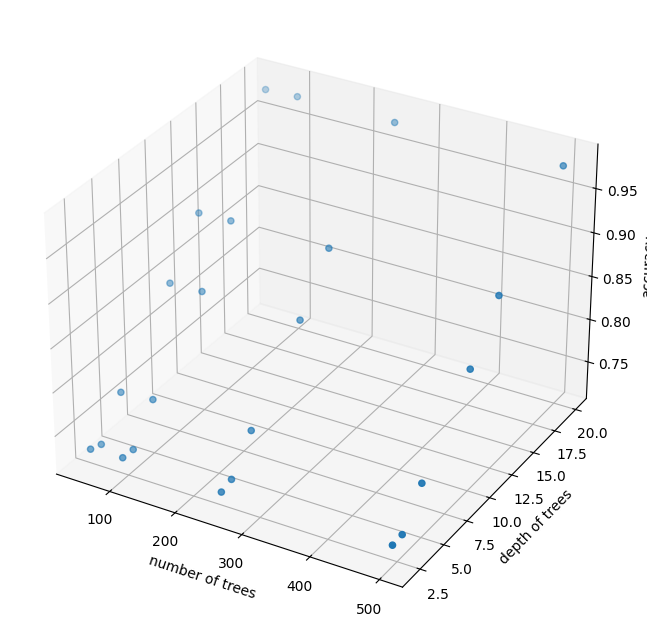

In [44]:
fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel('number of trees')
ax.set_ylabel('depth of trees')
ax.set_zlabel('accuracy')
plt.show()

In [46]:
rf = RandomForestClassifier(max_depth=20,random_state=0)
rf.fit(train,train_labels)
predictions = rf.predict(test)

In [47]:
acc = m.accuracy_score(test_labels,predictions)
prec = m.precision_score(test_labels,predictions)
recall = m.recall_score(test_labels,predictions)
print("Accuracy score: " + str(acc))
print("Precision score: " + str(prec))
print("Recall score: " + str(recall))

Accuracy score: 0.904154792260387
Precision score: 0.9225420664719789
Recall score: 0.8298724043032274


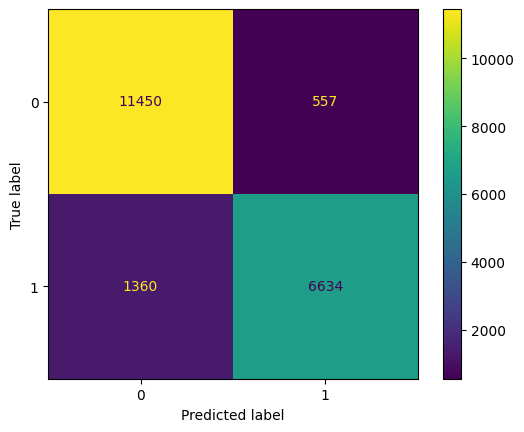

In [50]:
m.ConfusionMatrixDisplay(m.confusion_matrix(test_labels,predictions)).plot()